# Clustering: More Examples and Topics

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as sk_data
import sklearn.metrics as metrics

import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import seaborn as sns

#import matplotlib as mpl
import seaborn as sns
%matplotlib inline

## Continuation of Examples with Real Data

We prepare the data and clustering results to match that of the previous lecture.

In [54]:
from sklearn.datasets import fetch_20newsgroups

"""
categories = [
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'talk.religion.misc',
 'comp.graphics',
 'sci.space',
 'rec.autos',
 'rec.sport.baseball'
]
"""
categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
data = vectorizer.fit_transform(news_data.data)
data.shape

(1781, 9409)

In [56]:
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit_predict(data)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

euclidean_dists = metrics.euclidean_distances(data)

### MDS and Visualization

Let's visualize with MDS.   Note that MDS is a slow algorithm and we cannot do all 1700+ data points quickly. Instead, we will take a random sample.

In [34]:
import random
import sklearn.manifold
mds = sklearn.manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=0,
                   dissimilarity="precomputed", n_jobs=1)

n_items = euclidean_dists.shape[0]
subset = random.sample(range(n_items),200)

fit = mds.fit(euclidean_dists[subset][:,subset])
pos = fit.embedding_

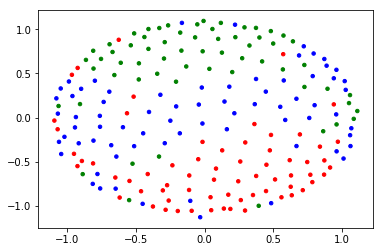

In [57]:
labels[subset]

cols = [['b', 'g', 'r'][l] for l in labels[subset]]
plt.scatter(pos[:, 0], pos[:, 1], s=12, c=cols)

We can get a much nicer picture of the data by projecting onto the plane that passes through the three cluster centers when $k =3$. 

In [64]:
# Now subtract off the first centers from the two others
# to get the vectors that span the space
#projection_vectors = np.zeros((2, 9409))
#projection_vectors[0] = centroids[1] - centroids[0]
#projection_vectors[1] = centroids[2] - centroids[0]
M = np.array([[-1, 1, 0], [-1, 0, 1]])
projection_vectors = M @ centroids

# Now orthogonalize the matrix so we can use it to project. 
Q = sp.linalg.orth(projection_vectors.transpose())

projected_data = data @ Q # This does the projection.
projected_data.shape

(1781, 2)

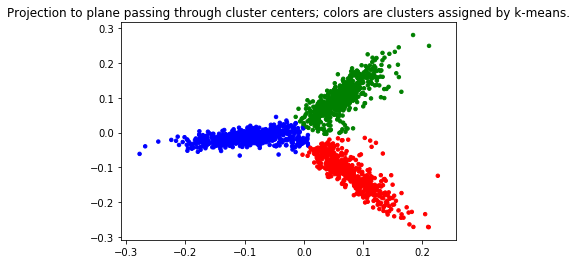

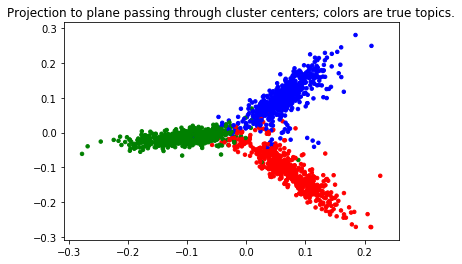

In [65]:
cols = [['b', 'g', 'r', 'c', 'm', 'y', 'k'][l] for l in labels]
plt.scatter(projected_data[:, 0], projected_data[:, 1], s=12, c=cols)
plt.title('Projection to plane passing through cluster centers; colors are clusters assigned by k-means.')
plt.show()
cols = [['b', 'g', 'r', 'c', 'm', 'y', 'k'][l] for l in news_data.target]
plt.scatter(projected_data[:, 0], projected_data[:, 1], s=12, c=cols)
plt.title('Projection to plane passing through cluster centers; colors are true topics.')
plt.show()

## Hierarchical clustering

### Example with synthetic data

We will use the same synthetic data that we did in the $k$-means case: three "blobs" living in 30 dimensions.

In [4]:
(X, y) = sk_data.make_blobs(n_samples=100, centers=3, n_features=30,
                            center_box=(-10.0, 10.0),random_state=0)

As a reminder, we reproduce some visualizations: the raw data and an embedding into two dimensions using MDS.

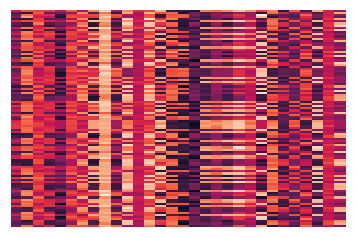

In [5]:
_ = sns.heatmap(X, xticklabels=False, yticklabels=False, linewidths=0,cbar=False)

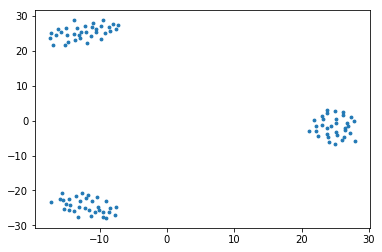

In [6]:
import sklearn.manifold
euclidean_dists = metrics.euclidean_distances(X)
mds = sklearn.manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=0,
                           dissimilarity="precomputed", n_jobs=1)
fit = mds.fit(euclidean_dists)
pos = fit.embedding_
_ = plt.scatter(pos[:, 0], pos[:, 1], s=8)

Hierarchical clustering is available in scikit-learn, but there is a more developed set of tools in the scipy package and that is the recommended one to use. The [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) explains the output of the `.linkage()` method.

In [9]:
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance
# linkages = ['single','complete','average','weighted']
Z = hierarchy.linkage(X, method='complete')
print(Z)

[[ 81.          92.           4.74889973   2.        ]
 [ 54.          88.           4.75898726   2.        ]
 [ 29.          85.           4.82311157   2.        ]
 [ 24.          47.           4.96051963   2.        ]
 [ 67.          68.           5.02571505   2.        ]
 [ 20.          22.           5.13698512   2.        ]
 [ 10.          36.           5.16638985   2.        ]
 [ 40.          41.           5.21116397   2.        ]
 [ 65.          78.           5.33150835   2.        ]
 [ 76.          80.           5.36525041   2.        ]
 [  3.          66.           5.47949696   2.        ]
 [ 11.          48.           5.53700744   2.        ]
 [ 13.          44.           5.57269997   2.        ]
 [ 91.          98.           5.6281846    2.        ]
 [ 12.          61.           5.64760453   2.        ]
 [ 37.          69.           5.68765872   2.        ]
 [ 14.          25.           5.7515719    2.        ]
 [  5.          52.           5.75359032   2.        ]
 [ 38.    

In [10]:
T = hierarchy.to_tree(Z)
print(T.count)
print(T.left.count)
print(T.right.count)

100
34
66


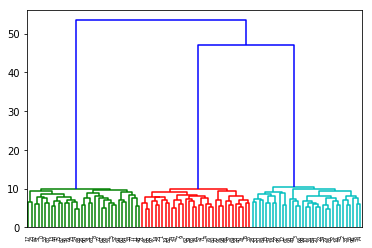

In [11]:
R = hierarchy.dendrogram(Z)

### Example with real data

In this example, we use the "20 Newsgroup" data provided as example data in scikit-learn.

In [12]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
data = vectorizer.fit_transform(news_data.data).todense()
data.shape

(1781, 9409)

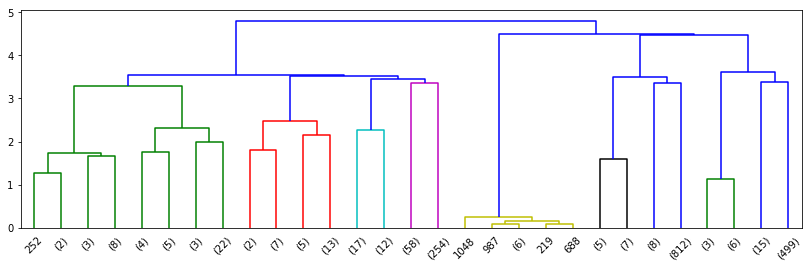

In [13]:
# metrics can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, 
# ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, 
# ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, 
# ‘sqeuclidean’, ‘yule’.
Z_20ng = hierarchy.linkage(data, method='ward', metric='euclidean')
plt.figure(figsize=(14,4))
R_20ng = hierarchy.dendrogram(Z_20ng, p=4, truncate_mode='level', show_leaf_counts=True)

We can try to choose the number of clusters using the clustering scoring methods.

In [14]:
clusters = hierarchy.fcluster(Z_20ng, 3, criterion='maxclust')
print(clusters.shape)
clusters

(1781,)


array([3, 3, 3, ..., 1, 3, 1], dtype=int32)

In [15]:
max_clusters = 20
s = np.zeros(max_clusters+1)
for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(Z_20ng, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(data,clusters,metric='euclidean')
plt.plot(range(2,len(s)),s[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

Text(0,0.5,'Silhouette score')

## Miscellaneous useful examples

You may find the following example useful for visualizing a number of (labeled) data sets simultaneously as one scatter plot.

In [67]:
import matplotlib.pyplot as plt
from numpy.random import random

colors = ['b', 'c', 'y', 'm', 'r']

A = plt.scatter(random(10), random(10), marker='x', color=colors[0])
B = plt.scatter(random(10), random(10), marker='o', color=colors[0])
C = plt.scatter(random(10), random(10), marker='o', color=colors[1])
D = plt.scatter(random(10), random(10), marker='o', color=colors[2])
E = plt.scatter(random(10), random(10), marker='o', color=colors[3])
F = plt.scatter(random(10), random(10), marker='o', color=colors[4])
G = plt.scatter(random(10), random(10), marker='x', color=colors[4])

plt.legend((A, B, C, D, E, F, G),
           ('AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

The [`tqdm` library](https://github.com/tqdm/tqdm) can be useful for displaying visual feedback when running algorithms over large amounts of data.

In [73]:
from tqdm import tqdm
from time import sleep

for i in tqdm(range(0,10)):
    sleep(1)

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]
